# NN4MG model analysis and multi-model comparison

This prelimitary work is inspired from Prof. Maria K. Cameron's notebook "A variational neural network-based solver for the committor problem". For a PDE that can be expressed as a Euler-Lagrangian equation, its solution is identical to the minimizer of a calculous of variation problem. The commiter problem is formulated from the PDE, while our case is formulated from the variational problem. In out past works, we find the solution by solving the Euler-Lanrangian equation. But this approach has limitations: if we want to modify the misfit (the integrand of the functional), we need to put non-trivial effort to derive the new Euler-Lagrangian, find the diffusion coefficients and a correct discretization. Even worse, some reasonabel choices of misfit leads to Euler-Lagrangian that isn't uniformly elliptic and has singularities, which becomes impossible to be solved. Therefore, it worth to consider minimizing the variational problem directly. The easiest choice to try first is training a neural network as an approximation of $x(s)$ (or $s(x)$). 

Let $\mathcal{N}(s)=x$ be a $\mathbb{R}^2$ to $\mathbb{R}^2$ be a neural network,

We propose a solution model: 
$$x_1(s) = x_1^0(s) + s_1(1-s_1)\mathcal{N}_1(s)$$
$$x_2(s) = x_2^0(s) + s_2(1-s_2)\mathcal{N}_2(s)$$
Where $x_1^0(s)$ and $x_2^0(s)$ are the initial guess of the map from computational space to physical space. The quadratic coefficients s_1(1-s_1) and s_2(1-s_2) are here to strictly enforce Dirichlet boundary conditions: $x_1$ must equal to initial value where $s_1=0,1$, and $x_2$ must equal to initial value where $s_2=0,1$.

For now, a simple MLP is used as the neural network. 

The loss function is constructed as: $\mathcal{L} = \mathcal{L}_	ext{int} + \mathcal{L}_	ext{Neu}$. Where $\mathcal{L}_	ext{int} = 
rac{1}{N} \sum_k^N \sigma_1^2 M_{ij} x_{i,lpha} x_{j,lpha}$, the average of misfit values at grid points. And $\mathcal{L}_	ext{Neu} = 	ext{Avg\_of\_North}(\partial_n x_1) + 	ext{Avg\_of\_South}(\partial_n x_1) + 	ext{Avg\_of\_West}(\partial_n x_2) + 	ext{Avg\_of\_East}(\partial_n x_2)$. The derivative of $x$ can be easily evaluated thanks to automatic differentiation.

This notebook loads multiple trained models and compares their deformed grids, misfit integrands, and skewness side by side using subfigures. Update `runs_spec` in the next cell. To override the analytic problem metric for misfit evaluation, set `metric_npz_path` to a metric grid (like `run_meshgen_demo.py`).


In [196]:
%matplotlib inline
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import torch

from nn4mg import (
    compute_misfit_field,
    compute_gradation_field,
    compute_skewness,
    load_grid_csv,
    metric_fn_from_npz,
    M_fun,
    M_fun_torch,
    M_fun_inv_torch,
    Model,
)


In [197]:
# Add or remove runs to compare.
runs_spec = [
    ("baseline", "identity"),
    ("wider", Path("../models/20260126_163909"))
]

# Set to None to use the analytic problem metric.
metric_npz_path = Path("data/harmonic_block9/Mp.npz")
if not metric_npz_path.exists():
    alt_metric_npz_path = Path("..") / "data/harmonic_block9/Mp.npz"
    metric_npz_path = alt_metric_npz_path if alt_metric_npz_path.exists() else None

grid_npz_path = Path("data/harmonic_block9/X.npz")
if not grid_npz_path.exists():
    alt_grid_npz_path = Path("..") / "data/harmonic_block9/X.npz"
    grid_npz_path = alt_grid_npz_path if alt_grid_npz_path.exists() else None

phys_metric_npz_path = Path("data/harmonic_block9/M.npz")
if not phys_metric_npz_path.exists():
    alt_phys_metric_npz_path = Path("..") / "data/harmonic_block9/M.npz"
    phys_metric_npz_path = (
        alt_phys_metric_npz_path if alt_phys_metric_npz_path.exists() else None
    )

metric_fn_npz = metric_fn_from_npz(str(metric_npz_path)) if metric_npz_path else None
phys_metric_fn_npz = metric_fn_from_npz(str(phys_metric_npz_path)) if phys_metric_npz_path else None

plot_ideal_grid = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32


In [198]:
class IdentityNet(torch.nn.Module):
    def forward(self, xy):
        return xy


def load_run(run_dir, device, dtype):
    if run_dir is None or str(run_dir).lower() in {"identity", "trivial"}:
        grid_dir = Path(".")
        x1_path = grid_dir / "x1.csv"
        x2_path = grid_dir / "x2.csv"

        net = IdentityNet()
        net.to(device=device, dtype=dtype)
        net.eval()

        return {
            "run_dir": None,
            "model_path": None,
            "width": 0,
            "depth": 0,
            "problem": 1,
            "formulation": "primal",
            "x1_path": x1_path,
            "x2_path": x2_path,
            "net": net,
        }
    run_dir = Path(run_dir)
    config_path = run_dir / "run_config.json"
    model_path = run_dir / "model.pt"
    if not model_path.exists():
        raise FileNotFoundError(f"Missing model: {model_path}")

    config = json.loads(config_path.read_text()) if config_path.exists() else {}
    args = config.get("args", {})
    model_cfg = config.get("model", {})

    width = model_cfg.get("width", args.get("width", 128))
    depth = model_cfg.get("depth", args.get("depth", 4))
    problem = args.get("problem", 1)
    formulation = args.get("formulation", "primal")

    grid_dir = Path(".")
    x1_path = grid_dir / args.get("x1", "x1.csv")
    x2_path = grid_dir / args.get("x2", "x2.csv")

    net = Model(width=width, depth=depth)
    state = torch.load(model_path, map_location=device)
    net.load_state_dict(state)
    net.to(device=device, dtype=dtype)
    net.eval()

    return {
        "run_dir": run_dir,
        "model_path": model_path,
        "width": width,
        "depth": depth,
        "problem": problem,
        "formulation": formulation,
        "x1_path": x1_path,
        "x2_path": x2_path,
        "net": net,
    }


def dcentral(x1, x2, sigma1, sigma2):
    dx1ds1 = np.zeros_like(x1)
    dx2ds2 = np.zeros_like(x2)

    dx2ds2[1:-1, :] = (x2[2:, :] - x2[:-2, :]) / (2.0 * sigma2)
    dx2ds2[0, :] = (-x2[2, :] + 4 * x2[1, :] - 3 * x2[0, :]) / (2.0 * sigma2)
    dx2ds2[-1, :] = -(-x2[-3, :] + 4 * x2[-2, :] - 3 * x2[-1, :]) / (2.0 * sigma2)

    dx1ds1[:, 1:-1] = (x1[:, 2:] - x1[:, :-2]) / (2.0 * sigma1)
    dx1ds1[:, 0] = (-x1[:, 2] + 4 * x1[:, 1] - 3 * x1[:, 0]) / (2.0 * sigma1)
    dx1ds1[:, -1] = -(-x1[:, -3] + 4 * x1[:, -2] - 3 * x1[:, -1]) / (2.0 * sigma1)

    return dx1ds1, dx2ds2


def compute_ideal_grid(net, X, Y, Nx1, Nx2, problem, device, dtype):
    ds1 = 1.0 / Nx1
    ds2 = 1.0 / Nx2
    dx1ds1, dx2ds2 = dcentral(X, Y, ds1, ds2)
    dx2ds1, dx1ds2 = dcentral(Y, X, ds1, ds2)

    M11, M12, M22 = M_fun(X, Y, problem=problem)
    p1 = M11 * dx1ds1**2 + M22 * dx2ds1**2 + 2.0 * M12 * dx1ds1 * dx2ds1
    p2 = M11 * dx1ds2**2 + M22 * dx2ds2**2 + 2.0 * M12 * dx1ds2 * dx2ds2

    sigma1 = np.sqrt(np.sum(np.abs(p1)) / np.sum(p1**2))
    sigma2 = np.sqrt(np.sum(np.abs(p2)) / np.sum(p2**2))
    ideal_cells_x = max(1, int(np.round(1.0 / sigma1)))
    ideal_cells_y = max(1, int(np.round(1.0 / sigma2)))

    xi = np.linspace(0.0, 1.0, ideal_cells_x + 1)
    eta = np.linspace(0.0, 1.0, ideal_cells_y + 1)
    X1_ideal, X2_ideal = np.meshgrid(xi, eta)
    xy_ideal = np.column_stack((X1_ideal.ravel(), X2_ideal.ravel()))
    xy_ideal = torch.from_numpy(xy_ideal).to(device=device, dtype=dtype)

    with torch.no_grad():
        out_ideal = net(xy_ideal)

    X_ideal = out_ideal[:, 0].reshape(X1_ideal.shape).detach().cpu().numpy()
    Y_ideal = out_ideal[:, 1].reshape(X2_ideal.shape).detach().cpu().numpy()

    return ideal_cells_x, ideal_cells_y, X_ideal, Y_ideal


def plot_grid_on_ax(ax, X, Y, title=None):
    ax.plot(X, Y, "k", linewidth=0.1)
    ax.plot(X.T, Y.T, "k", linewidth=0.1)
    ax.set_aspect("equal", adjustable="box")
    if title:
        ax.set_title(title)


def plot_scalar_on_ax(ax, X, Y, field, title=None, cmap="viridis", vmin=None, vmax=None):
    mesh = ax.pcolormesh(X, Y, field, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    if title:
        ax.set_title(title)
    return mesh


def load_harmonic_map(npz_path):
    data = np.load(npz_path)
    X1_map = data["X1"]
    X2_map = data["X2"]
    if X1_map.shape != X2_map.shape:
        raise ValueError(f"X1/X2 map shape mismatch: {X1_map.shape} vs {X2_map.shape}")
    return X1_map, X2_map


def warn_if_outside_unit_square(X_param, Y_param, label, tol=1e-6):
    mask = (X_param < -tol) | (X_param > 1.0 + tol) | (Y_param < -tol) | (Y_param > 1.0 + tol)
    if np.any(mask):
        frac = float(np.mean(mask)) * 100.0
        print(f"[{label}] {frac:.2f}% of points are outside [0, 1] in parameter space; clipping for mapping.")


def bilinear_interpolate_grid(grid, s1, s2):
    ny, nx = grid.shape
    s1 = np.clip(s1, 0.0, 1.0)
    s2 = np.clip(s2, 0.0, 1.0)
    x = s1 * (nx - 1)
    y = s2 * (ny - 1)
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    x1 = np.clip(x0 + 1, 0, nx - 1)
    y1 = np.clip(y0 + 1, 0, ny - 1)
    wx = x - x0
    wy = y - y0
    f00 = grid[y0, x0]
    f10 = grid[y0, x1]
    f01 = grid[y1, x0]
    f11 = grid[y1, x1]
    return (1.0 - wx) * (1.0 - wy) * f00 + wx * (1.0 - wy) * f10 + (1.0 - wx) * wy * f01 + wx * wy * f11


def map_param_grid_to_physical(X_param, Y_param, X1_map, X2_map):
    X_phys = bilinear_interpolate_grid(X1_map, X_param, Y_param)
    Y_phys = bilinear_interpolate_grid(X2_map, X_param, Y_param)
    return X_phys, Y_phys


In [199]:
def compute_cell_ratio_field(X, Y, eps=1e-12):
    x00 = X[:-1, :-1]
    y00 = Y[:-1, :-1]
    x10 = X[:-1, 1:]
    y10 = Y[:-1, 1:]
    x11 = X[1:, 1:]
    y11 = Y[1:, 1:]
    x01 = X[1:, :-1]
    y01 = Y[1:, :-1]

    area = 0.5 * np.abs(
        x00 * y10 - y00 * x10 +
        x10 * y11 - y10 * x11 +
        x11 * y01 - y11 * x01 +
        x01 * y00 - y01 * x00
    )
    area = np.maximum(area, eps)

    ratio = np.ones_like(area)
    if area.shape[0] > 1:
        r = np.maximum(area[1:, :] / area[:-1, :], area[:-1, :] / area[1:, :])
        ratio[:-1, :] = np.maximum(ratio[:-1, :], r)
        ratio[1:, :] = np.maximum(ratio[1:, :], r)
    if area.shape[1] > 1:
        r = np.maximum(area[:, 1:] / area[:, :-1], area[:, :-1] / area[:, 1:])
        ratio[:, :-1] = np.maximum(ratio[:, :-1], r)
        ratio[:, 1:] = np.maximum(ratio[:, 1:], r)

    accum = np.zeros_like(X, dtype=float)
    count = np.zeros_like(X, dtype=float)
    accum[:-1, :-1] += ratio
    accum[:-1, 1:] += ratio
    accum[1:, :-1] += ratio
    accum[1:, 1:] += ratio
    count[:-1, :-1] += 1
    count[:-1, 1:] += 1
    count[1:, :-1] += 1
    count[1:, 1:] += 1
    return accum / np.maximum(count, 1.0)

if not runs_spec:
    raise ValueError("runs_spec is empty. Add at least one run to compare.")

runs = []
for label, run_dir in runs_spec:
    run = load_run(run_dir, device=device, dtype=dtype)
    run["label"] = label

    X1, X2 = load_grid_csv(run["x1_path"], run["x2_path"])
    Nx1, Nx2 = np.shape(X1)

    xy_int = np.column_stack((X1.ravel(), X2.ravel()))
    xy_int = torch.from_numpy(xy_int).to(device=device, dtype=dtype)

    with torch.no_grad():
        out = run["net"](xy_int)

    X = out[:, 0].reshape(Nx2, Nx1).detach().cpu().numpy()
    Y = out[:, 1].reshape(Nx2, Nx1).detach().cpu().numpy()

    run.update({
        "X1": X1,
        "X2": X2,
        "X": X,
        "Y": Y,
        "Nx1": Nx1,
        "Nx2": Nx2,
    })

    if run["formulation"] == "primal":
        ideal_cells_x, ideal_cells_y, X_ideal, Y_ideal = compute_ideal_grid(
            run["net"], X, Y, Nx1, Nx2, run["problem"], device, dtype
        )
        run.update({
            "ideal_cells_x": ideal_cells_x,
            "ideal_cells_y": ideal_cells_y,
            "X_ideal": X_ideal,
            "Y_ideal": Y_ideal,
        })
    else:
        run.update({
            "ideal_cells_x": None,
            "ideal_cells_y": None,
            "X_ideal": None,
            "Y_ideal": None,
        })

    if metric_fn_npz is not None:
        metric_fn_selected = metric_fn_npz
        metric_inv_fn_selected = None
        metric_source = f"metric npz={metric_npz_path}"
    else:
        def metric_fn_selected(x1, x2, problem=run["problem"]):
            return M_fun_torch(x1, x2, problem=problem)

        def metric_inv_fn_selected(x1, x2, problem=run["problem"]):
            return M_fun_inv_torch(x1, x2, problem=problem)

        metric_source = f"metric problem={run['problem']}"

    misfit_field = compute_misfit_field(
        run["net"],
        X1,
        X2,
        metric_fn_selected,
        metric_inv_fn=metric_inv_fn_selected,
        device=device,
        dtype=dtype,
        formulation=run["formulation"],
        misfit_type="standard"
    )
    misfit_avg = float(np.mean(misfit_field))
    misfit_max = float(np.max(misfit_field))

    skew_field = compute_skewness(X, Y)
    skew_avg = float(np.mean(skew_field))
    skew_max = float(np.max(skew_field))

    gradation_field = compute_cell_ratio_field(X, Y)
    gradation_avg = float(np.mean(gradation_field))
    gradation_max = float(np.max(gradation_field))

    run.update({
        "misfit_field": misfit_field,
        "misfit_avg": misfit_avg,
        "misfit_max": misfit_max,
        "skew_field": skew_field,
        "skew_avg": skew_avg,
        "skew_max": skew_max,
        "gradation_field": gradation_field,
        "gradation_avg": gradation_avg,
        "gradation_max": gradation_max,
    })

    runs.append(run)

    ideal_msg = (
        f"ideal cells {run['ideal_cells_x']}x{run['ideal_cells_y']}"
        if run["formulation"] == "primal"
        else "dual formulation"
    )
    print(
        f"[{label}] width={run['width']}, depth={run['depth']}, "
        f"problem={run['problem']}, formulation={run['formulation']}, "
        f"{ideal_msg}, {metric_source}"
    )


[baseline] width=0, depth=0, problem=1, formulation=primal, ideal cells 124x124, metric npz=../data/harmonic_block9/Mp.npz
[wider] width=64, depth=4, problem=2, formulation=primal, ideal cells 41x33, metric npz=../data/harmonic_block9/Mp.npz


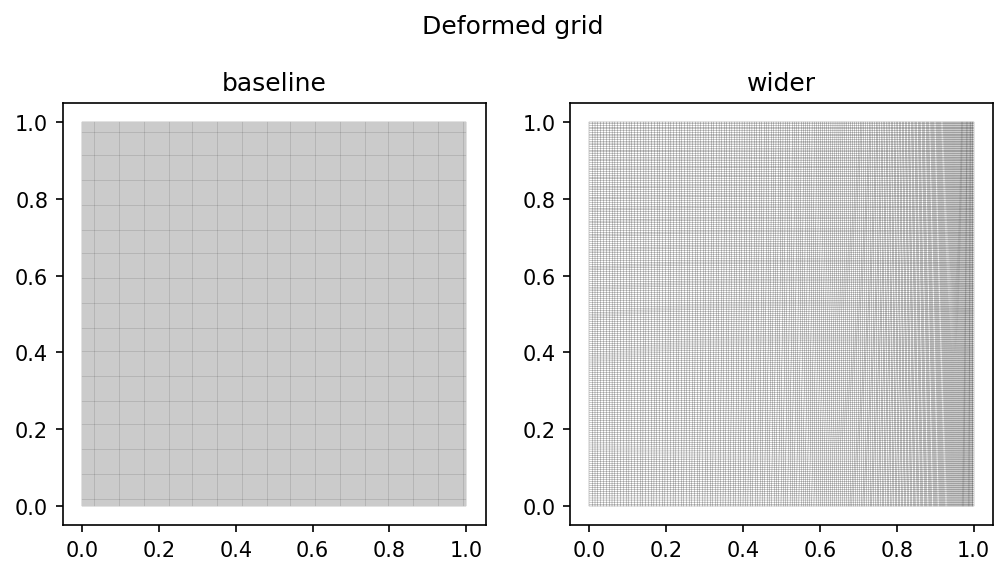

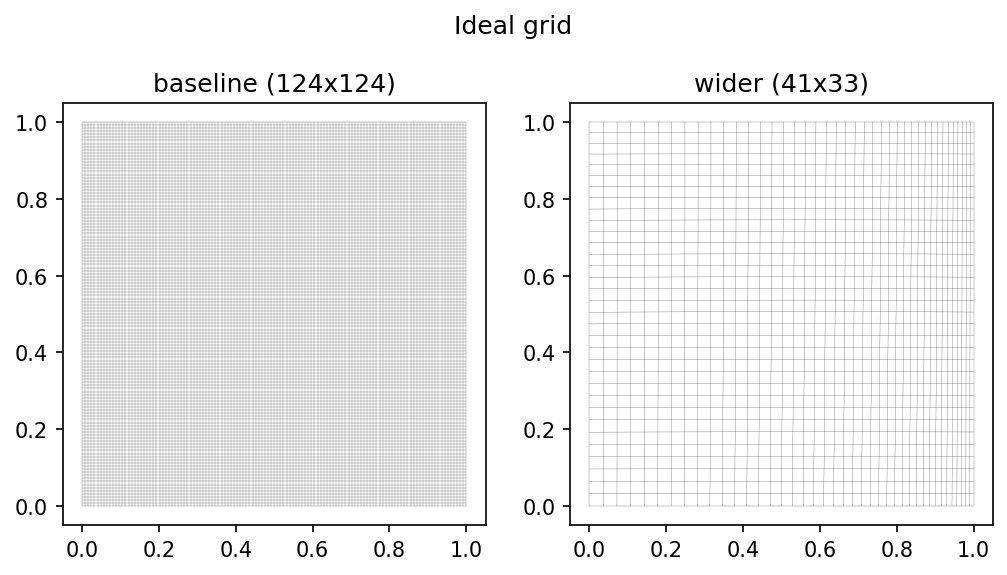

/var/folders/ps/xk3hpl_12hl8mxh4mflt_kh80000gn/T/ipykernel_21743/229909617.py:119: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(X, Y, field, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)


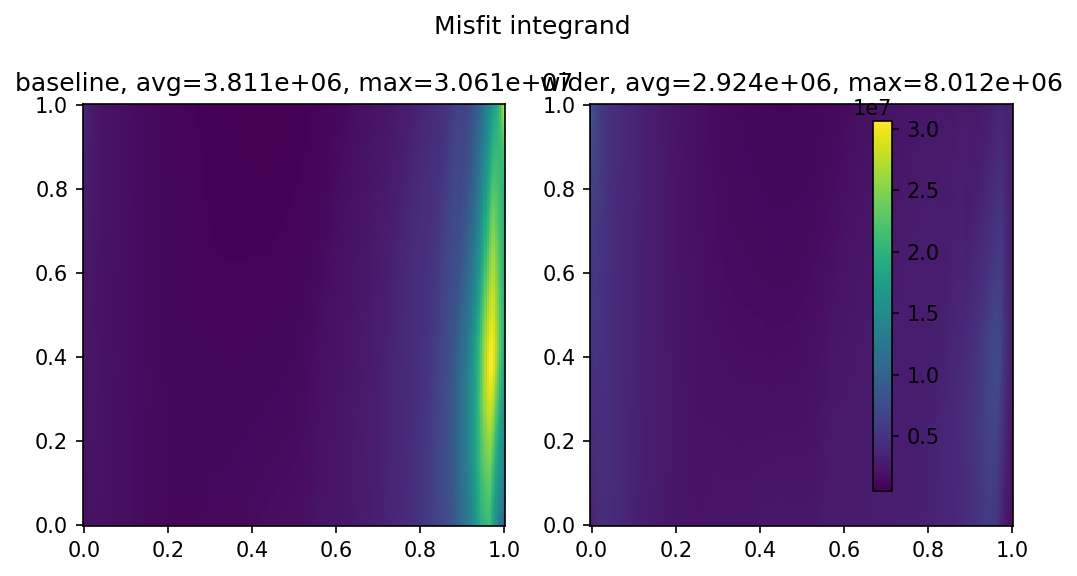

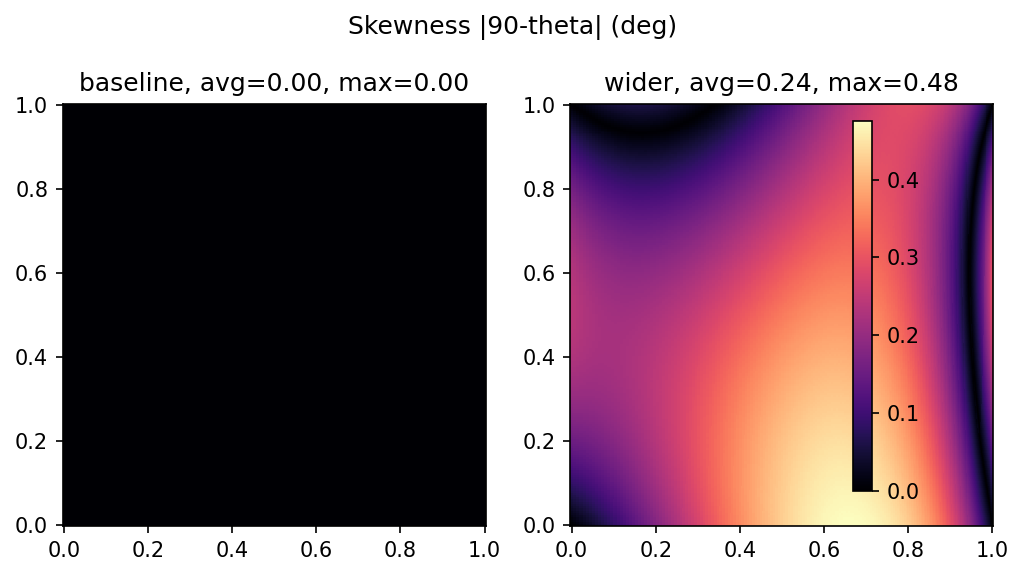

ValueError: not enough values to unpack (expected 2, got 0)

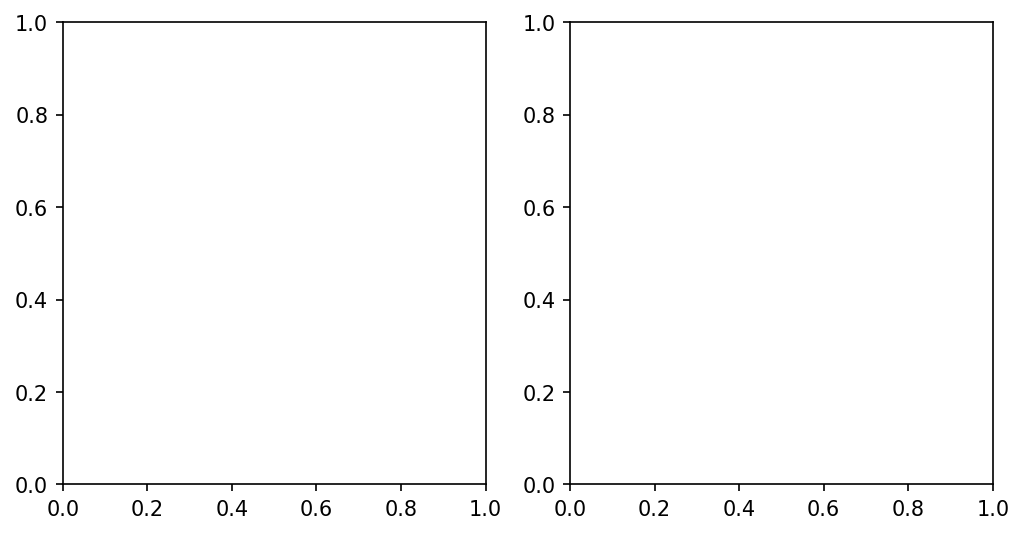

In [200]:
num_models = len(runs)
fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
axes = np.atleast_1d(axes)

for ax, run in zip(axes, runs):
    plot_grid_on_ax(ax, run["X"], run["Y"], title=run["label"])

fig.suptitle("Deformed grid")
fig.subplots_adjust(top=0.85)
plt.show()

if plot_ideal_grid:
    if any(run["formulation"] == "primal" for run in runs):
        fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
        axes = np.atleast_1d(axes)

        for ax, run in zip(axes, runs):
            if run["formulation"] != "primal":
                ax.text(0.5, 0.5, "dual formulation", ha="center", va="center")
                ax.set_axis_off()
                continue
            title = f"{run['label']} ({run['ideal_cells_x']}x{run['ideal_cells_y']})"
            plot_grid_on_ax(ax, run["X_ideal"], run["Y_ideal"], title=title)

        fig.suptitle("Ideal grid")
        fig.subplots_adjust(top=0.85)
        plt.show()
    else:
        print("Skipping ideal grid: all runs use the dual formulation.")

misfit_vmin = min(np.min(run["misfit_field"]) for run in runs)
misfit_vmax = max(np.max(run["misfit_field"]) for run in runs)

fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
axes = np.atleast_1d(axes)
meshes = []

for ax, run in zip(axes, runs):
    title = f"{run['label']}, avg={run['misfit_avg']:.3e}, max={run['misfit_max']:.3e}"
    mesh = plot_scalar_on_ax(
        ax,
        run["X"],
        run["Y"],
        run["misfit_field"],
        title=title,
        cmap="viridis",
        vmin=misfit_vmin,
        vmax=misfit_vmax,
    )
    meshes.append(mesh)

fig.colorbar(meshes[0], ax=axes.ravel().tolist(), shrink=0.8)
fig.suptitle("Misfit integrand")
fig.subplots_adjust(top=0.85)
plt.show()

skew_vmin = min(np.min(run["skew_field"]) for run in runs)
skew_vmax = max(np.max(run["skew_field"]) for run in runs)

fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
axes = np.atleast_1d(axes)
meshes = []

for ax, run in zip(axes, runs):
    title = f"{run['label']}, avg={run['skew_avg']:.2f}, max={run['skew_max']:.2f}"
    mesh = plot_scalar_on_ax(
        ax,
        run["X"],
        run["Y"],
        run["skew_field"],
        title=title,
        cmap="magma",
        vmin=skew_vmin,
        vmax=skew_vmax,
    )
    meshes.append(mesh)

fig.colorbar(meshes[0], ax=axes.ravel().tolist(), shrink=0.8)
fig.suptitle("Skewness |90-theta| (deg)")
fig.subplots_adjust(top=0.85)
plt.show()

grad_vmin = min(np.min(run["gradation_field"]) for run in runs)
grad_vmax = max(np.max(run["gradation_field"]) for run in runs)

fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
axes = np.atleast_1d(axes)
meshes = []

for ax, run in zip(axes, runs):
    title = f"{run['label']}, avg={run['gradation_avg']:.3e}, max={run['gradation_max']:.3e}"
    mesh = plot_scalar_on_ax(
        ax,
        run["X"],
        run["Y"],
        run["gradation_field"],
        title=title,
        cmap="inferno",
        vmin=grad_vmin,
        vmax=grad_vmax,
    )
    meshes.append(mesh)

fig.colorbar(meshes[0], ax=axes.ravel().tolist(), shrink=0.8)
fig.suptitle("Cell size ratio")
fig.subplots_adjust(top=0.85)
plt.show()


## Physical-space analysis (harmonic transform)

This section maps the deformed grids from parameter space into physical space using the harmonic transform grid in `X.npz`. Metric misfit is recomputed with `M.npz` and all fields are plotted on the mapped physical coordinates.


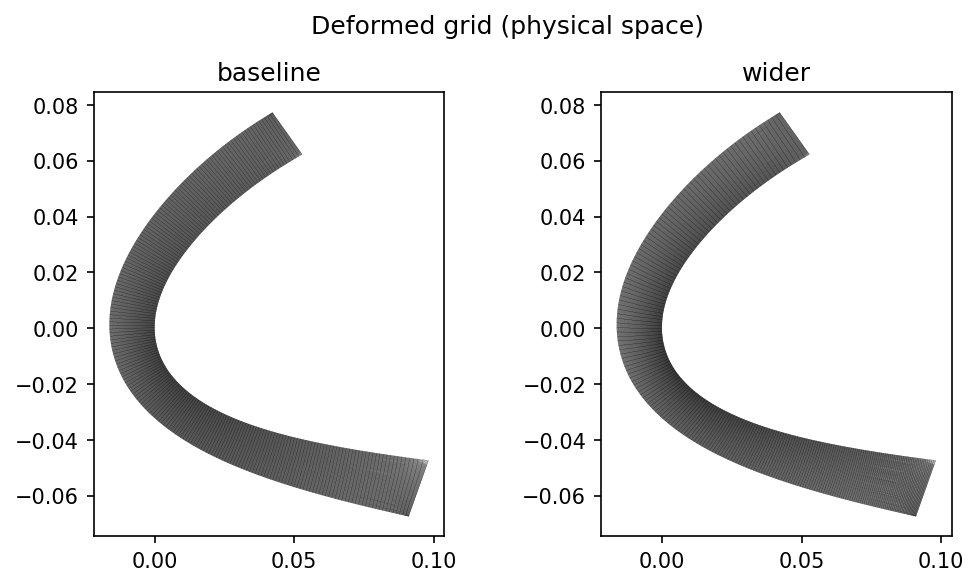

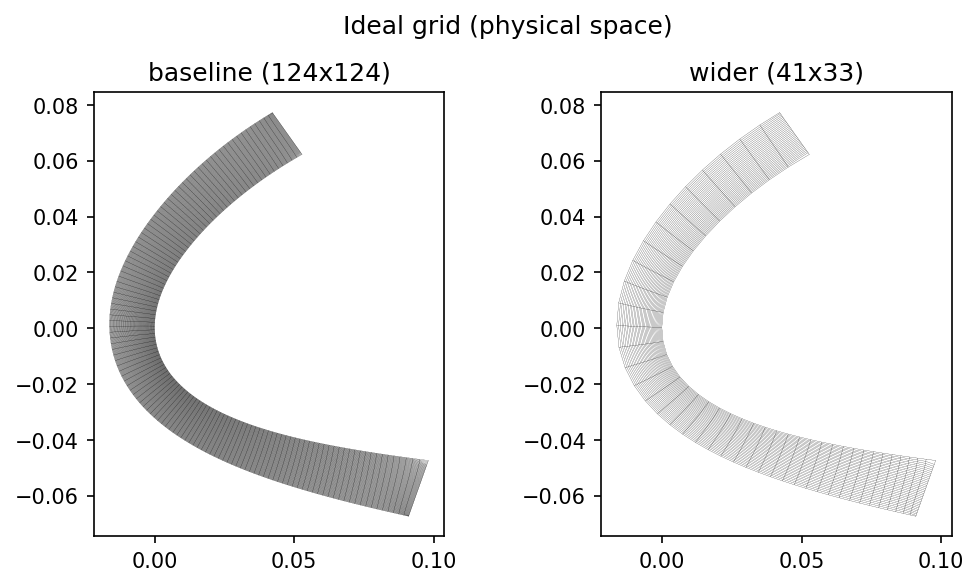

/var/folders/ps/xk3hpl_12hl8mxh4mflt_kh80000gn/T/ipykernel_21743/229909617.py:119: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(X, Y, field, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)


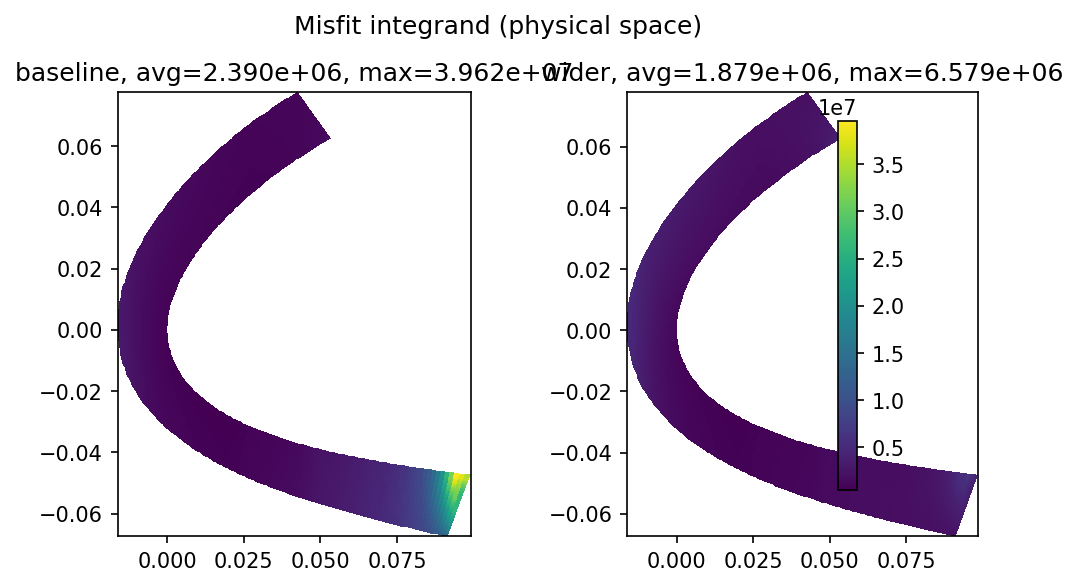

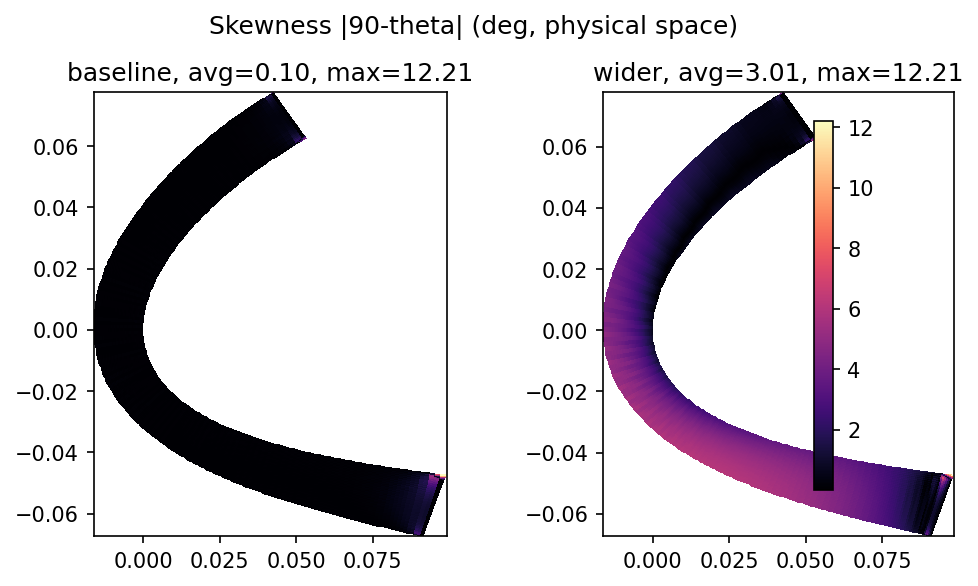

ValueError: not enough values to unpack (expected 2, got 0)

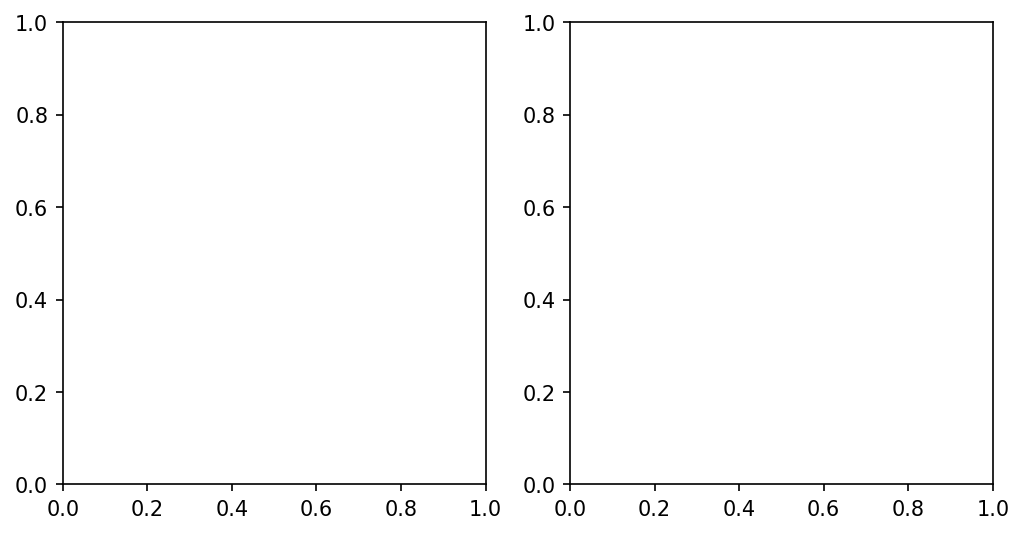

In [218]:
if grid_npz_path is None or not grid_npz_path.exists() or phys_metric_fn_npz is None:
    print("Skipping physical-space analysis: grid_npz_path or phys_metric_npz_path not found.")
else:
    X1_map, X2_map = load_harmonic_map(grid_npz_path)

    def compute_misfit_phys_fd(
        X_phys,
        Y_phys,
        X1_param,
        X2_param,
        metric_fn,
        lam_xi=1.0,
        lam_eta=1.0,
        misfit_type="standard",
    ):
        x1_vec = X1_param[0, :]
        x2_vec = X2_param[:, 0]
        dX_deta, dX_dxi = np.gradient(X_phys, x2_vec, x1_vec, edge_order=2)
        dY_deta, dY_dxi = np.gradient(Y_phys, x2_vec, x1_vec, edge_order=2)

        with torch.no_grad():
            x_t = torch.from_numpy(X_phys).to(device=device, dtype=dtype)
            y_t = torch.from_numpy(Y_phys).to(device=device, dtype=dtype)
            M11_t, M12_t, M22_t = metric_fn(x_t, y_t)

        M11 = M11_t.detach().cpu().numpy().reshape(X_phys.shape)
        M12 = M12_t.detach().cpu().numpy().reshape(X_phys.shape)
        M22 = M22_t.detach().cpu().numpy().reshape(X_phys.shape)

        q_xi = M11 * dX_dxi * dX_dxi + 2.0 * M12 * dX_dxi * dY_dxi + M22 * dY_dxi * dY_dxi
        q_eta = M11 * dX_deta * dX_deta + 2.0 * M12 * dX_deta * dY_deta + M22 * dY_deta * dY_deta

        if misfit_type == "standard":
            return (lam_xi**2) * q_xi + (lam_eta**2) * q_eta
        if misfit_type == "target1":
            return (lam_xi**2 * q_xi - 1.0) ** 2 + (lam_eta**2 * q_eta - 1.0) ** 2
        if misfit_type == "target2":
            return np.abs((q_xi - q_xi.mean()) / q_xi.mean()) + np.abs((q_eta - q_eta.mean()) / q_eta.mean())
        if misfit_type == "target3":
            def softplus(z):
                return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0)

            aux_xi = (q_xi - q_xi.mean()) / q_xi.mean()
            aux_eta = (q_eta - q_eta.mean()) / q_eta.mean()
            return (
                softplus(aux_xi)
                + softplus(-aux_xi)
                + softplus(aux_eta)
                + softplus(-aux_eta)
                - 4 * np.log(2)
            )
        raise ValueError(f"Unknown misfit_type: {misfit_type}")

    for run in runs:
        warn_if_outside_unit_square(run["X1"], run["X2"], run["label"])
        X_phys, Y_phys = map_param_grid_to_physical(run["X1"], run["X2"], X1_map, X2_map)
        run["X_phys"] = X_phys
        run["Y_phys"] = Y_phys

        skew_field_phys = compute_skewness(X_phys, Y_phys)
        run["skew_field_phys"] = skew_field_phys
        run["skew_avg_phys"] = float(np.mean(skew_field_phys))
        run["skew_max_phys"] = float(np.max(skew_field_phys))

        misfit_field_phys = compute_misfit_phys_fd(
            X_phys,
            Y_phys,
            run["X1"],
            run["X2"],
            phys_metric_fn_npz,
            misfit_type="standard",
        )
        run["misfit_field_phys"] = misfit_field_phys
        run["misfit_avg_phys"] = float(np.mean(misfit_field_phys))
        run["misfit_max_phys"] = float(np.max(misfit_field_phys))

        gradation_field_phys = compute_cell_ratio_field(X_phys, Y_phys)
        run["gradation_field_phys"] = gradation_field_phys
        run["gradation_avg_phys"] = float(np.mean(gradation_field_phys))
        run["gradation_max_phys"] = float(np.max(gradation_field_phys))

        if run["X_ideal"] is not None:
            X_ideal_phys, Y_ideal_phys = map_param_grid_to_physical(
                run["X_ideal"], run["Y_ideal"], X1_map, X2_map
            )
        else:
            X_ideal_phys, Y_ideal_phys = None, None
        run["X_ideal_phys"] = X_ideal_phys
        run["Y_ideal_phys"] = Y_ideal_phys

    num_models = len(runs)
    fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
    axes = np.atleast_1d(axes)

    for ax, run in zip(axes, runs):
        plot_grid_on_ax(ax, run["X_phys"], run["Y_phys"], title=run["label"])

    fig.suptitle("Deformed grid (physical space)")
    fig.subplots_adjust(top=0.85)
    plt.show()

    if plot_ideal_grid:
        if any(run["formulation"] == "primal" for run in runs):
            fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
            axes = np.atleast_1d(axes)

            for ax, run in zip(axes, runs):
                if run["formulation"] != "primal":
                    ax.text(0.5, 0.5, "dual formulation", ha="center", va="center")
                    ax.set_axis_off()
                    continue
                title = f"{run['label']} ({run['ideal_cells_x']}x{run['ideal_cells_y']})"
                plot_grid_on_ax(ax, run["X_ideal_phys"], run["Y_ideal_phys"], title=title)

            fig.suptitle("Ideal grid (physical space)")
            fig.subplots_adjust(top=0.85)
            plt.show()
        else:
            print("Skipping ideal grid (physical space): all runs use the dual formulation.")

    misfit_vmin = min(np.min(run["misfit_field_phys"]) for run in runs)
    misfit_vmax = max(np.max(run["misfit_field_phys"]) for run in runs)

    fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
    axes = np.atleast_1d(axes)
    meshes = []

    for ax, run in zip(axes, runs):
        title = f"{run['label']}, avg={run['misfit_avg_phys']:.3e}, max={run['misfit_max_phys']:.3e}"
        mesh = plot_scalar_on_ax(
            ax,
            run["X_phys"],
            run["Y_phys"],
            run["misfit_field_phys"],
            title=title,
            cmap="viridis",
            vmin=misfit_vmin,
            vmax=misfit_vmax,
        )
        meshes.append(mesh)

    fig.colorbar(meshes[0], ax=axes.ravel().tolist(), shrink=0.8)
    fig.suptitle("Misfit integrand (physical space)")
    fig.subplots_adjust(top=0.85)
    plt.show()

    skew_vmin = min(np.min(run["skew_field_phys"]) for run in runs)
    skew_vmax = max(np.max(run["skew_field_phys"]) for run in runs)

    fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
    axes = np.atleast_1d(axes)
    meshes = []

    for ax, run in zip(axes, runs):
        title = f"{run['label']}, avg={run['skew_avg_phys']:.2f}, max={run['skew_max_phys']:.2f}"
        mesh = plot_scalar_on_ax(
            ax,
            run["X_phys"],
            run["Y_phys"],
            run["skew_field_phys"],
            title=title,
            cmap="magma",
            vmin=skew_vmin,
            vmax=skew_vmax,
        )
        meshes.append(mesh)

    fig.colorbar(meshes[0], ax=axes.ravel().tolist(), shrink=0.8)
    fig.suptitle("Skewness |90-theta| (deg, physical space)")
    fig.subplots_adjust(top=0.85)
    plt.show()

    grad_vmin = min(np.min(run["gradation_field_phys"]) for run in runs)
    grad_vmax = max(np.max(run["gradation_field_phys"]) for run in runs)

    fig, axes = plt.subplots(1, num_models, figsize=(4 * num_models, 4), dpi=150)
    axes = np.atleast_1d(axes)
    meshes = []

    for ax, run in zip(axes, runs):
        title = f"{run['label']}, avg={run['gradation_avg_phys']:.3e}, max={run['gradation_max_phys']:.3e}"
        mesh = plot_scalar_on_ax(
            ax,
            run["X_phys"],
            run["Y_phys"],
            run["gradation_field_phys"],
            title=title,
            cmap="inferno",
            vmin=grad_vmin,
            vmax=grad_vmax,
        )
        meshes.append(mesh)

    fig.colorbar(meshes[0], ax=axes.ravel().tolist(), shrink=0.8)
    fig.suptitle("Cell size ratio (physical space)")
    fig.subplots_adjust(top=0.85)
    plt.show()
